# Project presentation

This project was realized for the course "machine learning for portfolio management and trading" teached by Sylvain Champonnois at ENSAE Paris. The subject was to do any data science project related with central bank data. We dicided to inspire our project from the article "A picture is worth a thousand words: Measuring investor sentiment by combining machine learning and photos from news" (Khaled Obaid, Kuntara Pukthuanthong, 2022). 

We want to scrap the ECB press release, taht are published approximately on a weekly basis and classify them using FinBERT in order to search some link between these press release and market return of sx5e index.

# We create necessary folders and .py files

In [1]:
import os

os.makedirs("utils", exist_ok=True)
os.makedirs("finbert_local", exist_ok=True)

In [2]:
%%writefile utils/__init__.py

UsageError: %%writefile is a cell magic, but the cell body is empty.


## Class for scrapping ecb press release list

In [3]:
%%writefile utils/ecb_scraper.py
import hashlib
import os
import re
import time
import pickle
import random
import asyncio
import aiohttp
import pandas as pd
import requests
from aiofiles import open as aio_open
from aiohttp import ClientError
from selenium import webdriver
from selenium.webdriver.chrome.service import Service as ChromeService
from selenium.common.exceptions import WebDriverException
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
from urllib.parse import urljoin


class ECBScraper:
    """
    ECB Press Release Scraper with verbosity control
    - verbose=0: no printing
    - verbose=1: basic progress
    - verbose=2: full printing (success/failure for each article)
    """

    BASE_URL = "https://www.ecb.europa.eu"
    START_URL = (
        "https://www.ecb.europa.eu/press/pubbydate/html/index.en.html?"
        "name_of_publication=Press%20release"
    )

    def __init__(self, pickle_path="ecb_press_releases_df.pkl",
                 scroll_pause_time=0.1, scroll_increment=50,
                 max_scroll_attempts=None, initial_wait=10, verbose=1):
        self.pickle_path = pickle_path
        self.scroll_pause_time = scroll_pause_time
        self.scroll_increment = scroll_increment
        self.max_scroll_attempts = max_scroll_attempts
        self.initial_wait = initial_wait
        self.verbose = verbose
        self.df = pd.DataFrame(columns=["Date", "Title", "URL"])
        self.existing_urls = set()
        self._load_data()

    # ------------------ Logging helpers ------------------
    def _log(self, msg, level=1):
        if self.verbose >= level:
            print(msg)

    def _log_progress(self, current, total):
        if self.verbose >= 1:
            print(f"📄 Scraped {current}/{total} articles")

    # ------------------ Pickle management -----------------
    def _load_data(self):
        if os.path.exists(self.pickle_path):
            try:
                self.df = pd.read_pickle(self.pickle_path)
                if not isinstance(self.df, pd.DataFrame):
                    raise ValueError("Pickle content invalid.")
                self.existing_urls = set(self.df["URL"].unique())
                self._log(f"✅ Loaded {len(self.df)} existing articles.", level=1)
            except Exception as e:
                self._log(f"⚠️ Error loading pickle: {e}. Starting fresh.", level=1)
                self.df = pd.DataFrame(columns=["Date", "Title", "URL"])
                self.existing_urls = set()
        else:
            self._log(f"ℹ️ No pickle found, starting fresh.", level=1)
            self.df = pd.DataFrame(columns=["Date", "Title", "URL"])
            self.existing_urls = set()

    def _save_data(self):
        if not self.df.empty:
            self.df.to_pickle(self.pickle_path)
            self._log(f"💾 Saved {len(self.df)} articles → {self.pickle_path}", level=1)

    # ------------------ Scraping --------------------------
    def _setup_driver(self):
        try:
            options = webdriver.ChromeOptions()
            options.add_argument("--headless")
            options.add_argument("--disable-gpu")
            options.add_argument("--no-sandbox")
            service = ChromeService(ChromeDriverManager().install())
            return webdriver.Chrome(service=service, options=options)
        except WebDriverException as e:
            self._log(f"❌ WebDriver setup error: {e}", level=1)
            return None

    def _scroll_page(self, driver):
        self._log("📜 Scrolling page...", level=1)
        attempt = 0
        while True:
            last_scroll_position = driver.execute_script("return window.pageYOffset;")
            driver.execute_script(f"window.scrollBy(0, {self.scroll_increment});")
            time.sleep(self.scroll_pause_time)
            new_scroll_position = driver.execute_script("return window.pageYOffset;")
            if new_scroll_position == last_scroll_position:
                self._log("✅ Reached page bottom.", level=1)
                break
            attempt += 1
            if self.max_scroll_attempts and attempt >= self.max_scroll_attempts:
                self._log("⚠️ Max scroll attempts reached.", level=1)
                break

    def _extract_articles(self, html_content):
        soup = BeautifulSoup(html_content, "html.parser")
        main_content = soup.find("div", id="ecb-content-col") or soup.find("main")
        if not main_content:
            self._log("⚠️ Could not find main content section.", level=1)
            return []

        articles = []
        current_date = None
        sort_wrapper = main_content.find("div", class_="sort-wrapper")
        if not sort_wrapper:
            self._log("⚠️ No sort-wrapper found.", level=1)
            return []

        dl = sort_wrapper.find("dl", recursive=False)
        if not dl:
            self._log("⚠️ No <dl> in sort-wrapper.", level=1)
            return []

        for tag in dl.find_all(["dt", "dd"], recursive=False):
            if tag.name == "dt":
                current_date = tag.get_text(strip=True)
            elif tag.name == "dd" and current_date:
                cat_div = tag.find("div", class_="category")
                title_div = tag.find("div", class_="title")
                if not (cat_div and title_div):
                    continue
                if cat_div.get_text(strip=True) != "Press release":
                    continue
                link_tag = title_div.find("a", href=True)
                if not link_tag:
                    continue
                url = urljoin(self.BASE_URL, link_tag["href"])
                if "/press/pr/" not in url:
                    continue
                title = link_tag.get_text(strip=True)
                articles.append({"Date": current_date, "Title": title, "URL": url})
        return articles

    def scrape_and_update(self):
        driver = self._setup_driver()
        if not driver:
            return

        try:
            self._log(f"🌐 Navigating to {self.START_URL}", level=1)
            driver.get(self.START_URL)
            time.sleep(self.initial_wait)
            self._scroll_page(driver)
            html = driver.page_source
        except Exception as e:
            self._log(f"❌ Error scraping: {e}", level=1)
            return
        finally:
            driver.quit()

        articles = self._extract_articles(html)
        self._log(f"📰 Found {len(articles)} articles total.", level=1)
        new_articles = [a for a in articles if a["URL"] not in self.existing_urls]

        if not new_articles:
            self._log("ℹ️ No new articles found.", level=1)
            return

        new_df = pd.DataFrame(new_articles)
        self.df = pd.concat([new_df, self.df]).drop_duplicates("URL", keep="first").reset_index(drop=True)
        self.existing_urls.update(new_df["URL"])
        self._save_data()
        self._log(f"✅ Added {len(new_articles)} new articles.", level=1)

    # ------------------ Async fetching -------------------
    async def _fetch_article(self, session, url, retries=3):
        """
        Fetch the text content of one article from its URL asynchronously.
        Preserves the order of <h1>, <h3>, <p>, <ul>/<ol> and relevant <div> across <main>,
        while ignoring full divs like 'address-box -top-arrow' and 'see-also-boxes'.
        Avoids duplicated text.
        """
        for attempt in range(retries):
            try:
                async with session.get(url, timeout=20) as resp:
                    if resp.status != 200:
                        raise aiohttp.ClientError(f"Status {resp.status}")
                    html = await resp.text()
                    soup = BeautifulSoup(html, "html.parser")

                    main = soup.find("main")
                    if not main:
                        return ""

                    # Remove unwanted sections
                    for div in main.find_all("div", class_=["address-box", "-top-arrow", "see-also-boxes"]):
                        div.decompose()

                    content = []
                    seen_text = set()

                    # Add main headline <h1> first
                    h1 = main.find("h1", class_="ecb-pressContentTitle")
                    if h1:
                        text = h1.get_text(strip=True)
                        if text:
                            content.append(text)
                            seen_text.add(text)

                    # Traverse all sections individually
                    for section in main.find_all("div", class_="section"):
                        for element in section.find_all(["h3", "p", "ul", "ol"], recursive=True):
                            if element.name in ["h3", "p"]:
                                text = element.get_text(strip=True)
                                if text and text not in seen_text:
                                    content.append(text)
                                    seen_text.add(text)
                            elif element.name in ["ul", "ol"]:
                                for li in element.find_all("li"):
                                    li_text = li.get_text(strip=True)
                                    if li_text and li_text not in seen_text:
                                        content.append(f"• {li_text}")
                                        seen_text.add(li_text)

                    return "\n\n".join(content).strip()

            except Exception as e:
                wait = 2 ** attempt + random.uniform(0, 0.5)
                self._log(f"⚠️ Error fetching {url} ({e}), retrying in {wait:.1f}s...", level=2)
                await asyncio.sleep(wait)

        self._log(f"❌ Failed to fetch {url} after {retries} retries.", level=2)
        return ""

    async def _save_article(self, semaphore, session, row, folder):
        async with semaphore:
            title, url = row.Title, row.URL
            date = str(row.Date)
            safe_title = re.sub(r"[^a-zA-Z0-9 _-]", "_", title)

            # Add formatted date string (year_monthname_day)
            parts = date.split()
            if len(parts) >= 3:
                day, month, year = parts[0], parts[1], parts[2]
                date_str = f"{year}_{month}_{day}"
            else:
                date_str = re.sub(r"[^0-9]", "", date)[:8] or "unknown"

            if len(safe_title) > 230:
                safe_title = safe_title[:230]
            safe_title = f"{safe_title}_{date_str}"

            file_path = os.path.join(folder, f"{safe_title}.txt")

            if os.path.exists(file_path):
                if self.verbose == 2:
                    self._log(f"⏩ Skipping '{title}' (already saved)", level=2)
                return

            try:
                text = await self._fetch_article(session, url)
                if not text or not text.strip():
                    if self.verbose >= 2:
                        self._log(f"⚠️ Skipping '{title}' (fetch failed or empty content)", level=2)
                    return

                async with aio_open(file_path, "w", encoding="utf-8") as f:
                    await f.write(text)

                if self.verbose == 2:
                    self._log(f"✅ Saved '{title}'", level=2)

            except Exception as e:
                if self.verbose >= 2:
                    self._log(f"⚠️ Fetch failed for '{title}' ({e}), no file created.", level=2)


    async def scrape_all_texts_to_files_async(self, folder="ecb_press_release", concurrency=6):
        """
        Scrape all articles in self.df and save them as text files asynchronously.
        The final count of saved articles is computed by counting files in the folder.
        """
        os.makedirs(folder, exist_ok=True)
        n = len(self.df)

        headers = {
            "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) "
                        "AppleWebKit/537.36 (KHTML, like Gecko) "
                        "Chrome/118.0 Safari/537.36"
        }

        semaphore = asyncio.Semaphore(concurrency)
        connector = aiohttp.TCPConnector(limit_per_host=concurrency, force_close=True)

        async with aiohttp.ClientSession(headers=headers, connector=connector) as session:
            tasks = [self._save_article(semaphore, session, row, folder)
                    for row in self.df.itertuples(index=False)]
            await asyncio.gather(*tasks)

        # Count saved files in folder
        saved_count = len([f for f in os.listdir(folder) if f.endswith(".txt")])
        self._log(f"📄 Scraped {saved_count}/{n} articles successfully", level=1)
        self._log(f"🎉 All texts attempted to save in '{folder}/'", level=1)
        
    # ------------------ Async fetching (summaries only) -------------------
    async def _fetch_article_summary(self, session, url, retries=3):
        """
        Fetch only the summary part of an ECB press release.
        - Normally takes the first <ul> inside <main>.
        - If the first <ul> contains an <li> with text including 'PRESS RELEASE',
          then takes the second <ul> instead.
        - Some articles does not have summary at the begining si it's finally not suitable for our project.
        """
        for attempt in range(retries):
            try:
                async with session.get(url, timeout=20) as resp:
                    if resp.status != 200:
                        raise aiohttp.ClientError(f"Status {resp.status}")
                    html = await resp.text()
                    soup = BeautifulSoup(html, "html.parser")

                    main = soup.find("main")
                    if not main:
                        return ""

                    # Remove irrelevant divs
                    for div in main.find_all("div", class_=["address-box", "-top-arrow", "see-also-boxes"]):
                        div.decompose()

                    # Find all <ul> inside <main>
                    uls = [
                        ul for ul in main.find_all("ul", recursive=True)
                        if not any(x in (ul.get("class") or []) for x in ["social", "breadcrumb"])
                    ]
                    if not uls:
                        return ""

                    chosen_ul = uls[0]

                    # Check if the first UL has an LI containing "PRESS RELEASE"
                    first_ul_texts = [li.get_text(strip=True).upper() for li in uls[0].find_all("li")]
                    if any("PRESS RELEASE" in t for t in first_ul_texts) and len(uls) > 1:
                        chosen_ul = uls[1]

                    summary_points = []
                    seen_text = set()

                    # Only take direct li children (not nested)
                    for li in chosen_ul.find_all("li", recursive=False):
                        li_text = li.get_text(strip=True)
                        if li_text and li_text not in seen_text:
                            summary_points.append(f"• {li_text}")
                            seen_text.add(li_text)

                    return "\n".join(summary_points).strip()

            except Exception as e:
                wait = 2 ** attempt + random.uniform(0, 0.5)
                self._log(f"⚠️ Error fetching summary {url} ({e}), retrying in {wait:.1f}s...", level=2)
                await asyncio.sleep(wait)

        self._log(f"❌ Failed to fetch summary {url} after {retries} retries.", level=2)
        return ""

    async def _save_summary(self, semaphore, session, row, folder):
        async with semaphore:
            title, url = row.Title, row.URL
            date = str(row.Date)
            safe_title = re.sub(r"[^a-zA-Z0-9 _-]", "_", title)

            # Add formatted date string (year_monthname_day)
            parts = date.split()
            if len(parts) >= 3:
                day, month, year = parts[0], parts[1], parts[2]
                date_str = f"{year}_{month}_{day}"
            else:
                date_str = re.sub(r"[^0-9]", "", date)[:8] or "unknown"

            if len(safe_title) > 230:
                safe_title = safe_title[:230]
            safe_title = f"{safe_title}_{date_str}"

            file_path = os.path.join(folder, f"{safe_title}.txt")

            if os.path.exists(file_path):
                if self.verbose == 2:
                    self._log(f"⏩ Skipping summary '{title}' (already saved)", level=2)
                return

            try:
                summary = await self._fetch_article_summary(session, url)
                if not summary or not summary.strip():
                    if self.verbose >= 2:
                        self._log(f"⚠️ Skipping summary '{title}' (fetch failed or empty content)", level=2)
                    return

                async with aio_open(file_path, "w", encoding="utf-8") as f:
                    await f.write(summary)

                if self.verbose == 2:
                    self._log(f"✅ Saved summary '{title}'", level=2)

            except Exception as e:
                if self.verbose >= 2:
                    self._log(f"⚠️ Fetch failed for summary '{title}' ({e}), no file created.", level=2)

    async def scrape_all_summaries_to_files_async(self, folder="ecb_press_release_summary", concurrency=6):
        """
        Scrape only the summaries (first <ul> list inside main) of all articles in self.df
        and save them as text files asynchronously.
        """
        os.makedirs(folder, exist_ok=True)
        n = len(self.df)

        headers = {
            "User-Agent": (
                "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) "
                "AppleWebKit/537.36 (KHTML, like Gecko) "
                "Chrome/118.0 Safari/537.36"
            )
        }

        semaphore = asyncio.Semaphore(concurrency)
        connector = aiohttp.TCPConnector(limit_per_host=concurrency, force_close=True)

        async with aiohttp.ClientSession(headers=headers, connector=connector) as session:
            tasks = [self._save_summary(semaphore, session, row, folder)
                     for row in self.df.itertuples(index=False)]
            await asyncio.gather(*tasks)

        saved_count = len([f for f in os.listdir(folder) if f.endswith(".txt")])
        self._log(f"📄 Saved {saved_count}/{n} summaries successfully", level=1)
        self._log(f"🎉 All summaries attempted to save in '{folder}/'", level=1)

Overwriting utils/ecb_scraper.py


## Class for loading finbert model

In [4]:
%%writefile utils/finbert_loader.py
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import os
import re



class FinBERTLoader:
    """
    Class to manage loading and saving of FinBERT model and tokenizer.
    Handles automatic downloading or loading from local storage.
    """
    
    def __init__(self, model_name="ProsusAI/finbert", local_dir="./finbert_local"):
        """
        Initialize the FinBERT loader.
        
        Args:
            model_name (str): HuggingFace model name
            local_dir (str): Directory to save/load the model locally
        """
        self.model_name = model_name
        self.local_dir = local_dir
        self.model = None
        self.tokenizer = None
        
    def load(self):
        """
        Load the model and tokenizer, either from local storage if available,
        or download from HuggingFace if not.
        """
        if self._is_model_cached():
            print("Loading FinBERT from local storage...")
            self.model = AutoModelForSequenceClassification.from_pretrained(self.local_dir)
            self.tokenizer = AutoTokenizer.from_pretrained(self.local_dir)
        else:
            print("Downloading FinBERT from HuggingFace...")
            self.model = AutoModelForSequenceClassification.from_pretrained(self.model_name)
            self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
            self._save_local()
            
        print("FinBERT loaded successfully!")
        return self
    
    def _is_model_cached(self):
        """Check if model files exist in local directory."""
        return os.path.exists(self.local_dir) and os.path.exists(os.path.join(self.local_dir, "config.json"))
    
    def _save_local(self):
        """Save model and tokenizer to local directory."""
        print("Saving model locally for future use...")
        os.makedirs(self.local_dir, exist_ok=True)
        self.model.save_pretrained(self.local_dir)
        self.tokenizer.save_pretrained(self.local_dir)

    def _chunk_text(self, tokens, max_length=512):
        """Helper to split tokens into chunks of max_length."""
        for i in range(0, len(tokens), max_length):
            chunk = tokens[i:i + max_length]
            yield chunk

    def _from_text_to_tokens(self, text):
        """
        Tokenize the input text using the FinBERT tokenizer.
        For texts longer than 512 tokens, splits into chunks.
        Returns list of tokenized inputs suitable for the model.
        """
        if not self.tokenizer:
            raise RuntimeError("Tokenizer not loaded. Call load() first.")
            
        # First encode without special tokens to get raw tokens
        tokens = self.tokenizer.encode(text, add_special_tokens=False)
        
        # If text is short enough, process normally
        if len(tokens) <= 512:
            return [self.tokenizer(text, return_tensors="pt", truncation=True, 
                                 max_length=512, padding=True)]
        
        # For long texts, split into chunks
        all_inputs = []
        for chunk in self._chunk_text(tokens):
            # Decode chunk back to text and re-encode properly with special tokens
            chunk_text = self.tokenizer.decode(chunk)
            inputs = self.tokenizer(chunk_text, return_tensors="pt", 
                                  truncation=True, max_length=512, padding=True)
            all_inputs.append(inputs)
            
        return all_inputs

    def text_to_dic(self, text):
            if not self.model or not self.tokenizer:
                raise RuntimeError("Model not loaded. Call load() first.")
                
            dic = {'positivity': [], 'negativity': [], 'neutrality': [], 'nb_token': []}
            for line in clean_and_filter_lines(text):
                inputs_list = self._from_text_to_tokens(line)
                all_logits = []
            
                
                for inputs in inputs_list:
                    outputs = self.model(**inputs)
                    logits = outputs.logits
                    dic['positivity'].append(logits[0][0].item())
                    dic['negativity'].append(logits[0][1].item())
                    dic['neutrality'].append(logits[0][2].item())
                    dic['nb_token'].append(inputs['input_ids'].shape[1])
            return(dic)
            
def clean_and_filter_lines2(text):
    lines = text.splitlines()
    cleaned_lines = []
    for line in lines:
        line = line.strip()
        if not line:
            continue
        if len(line) < 150:
            continue
        if re.match(r'^[\d\-\s\+\(\)]+$', line):
            continue
        if re.search(r'https?://', line) or re.search(r'\S+@\S+\.\S+', line):
            continue
        if line.lower().startswith('sources: '):
            continue
        cleaned_lines.append(line)
    return cleaned_lines

def clean_and_filter_lines(text):
    lines = text.split('\n')
    
    cleaned_lines = []
    for line in lines:
        line = line.strip()
        if not line:
            continue
        
        if len(line) < 10:
            continue
        
        if re.match(r'^[\d\-\s\+\(\)]+$', line):  
            continue
        
        if re.search(r'\d{5,}', line):
            continue
        
        cleaned_lines.append(line)
    
    return cleaned_lines

def dic_to_score_proba(dic, token_weighted = True, treshold = 0):
    def softmax(x):
        e_x = torch.exp(x - torch.max(x))
        return e_x / e_x.sum(dim=0)
    total = 0
    sum_score = 0
    for i in range(len(dic['positivity'])):
        logits = torch.tensor([dic['positivity'][i], dic['negativity'][i], dic['neutrality'][i]])
        probs = softmax(logits)
        if probs[2]> treshold:
            continue
        else:
            score = probs[1] - probs[0]
            if token_weighted:
                score = score * dic['nb_token'][i]
            sum_score += score
            if token_weighted:
                total += dic['nb_token'][i]
            else:
                total += 1
    if total > 0:
        final_score = sum_score / total
    else:
        return(0)
    return(final_score.item())


def dic_to_score_logits(dic, token_weighted = True, treshold = 0):
        total = 0
        sum_score = 0
        for i in range(len(dic['positivity'])):
            if dic['neutrality'][i]> treshold:
                continue
            score = dic['negativity'][i] - dic['positivity'][i]
            if token_weighted:
                score = score * dic['nb_token'][i]
            sum_score += score
            if token_weighted:
                total += dic['nb_token'][i]
            else:
                total += 1
        if total > 0:
            final_score = sum_score / total
        else:
            return(0)
        return(final_score)
def dic_to_proba_as_article(dic):
    def softmax(x):
        e_x = torch.exp(x - torch.max(x))
        return e_x / e_x.sum(dim=0)
    score = 0
    for i in range(len(dic['positivity'])):
        logits = torch.tensor([dic['positivity'][i], dic['negativity'][i], dic['neutrality'][i]])
        probs = softmax(logits)
        score += probs[1]
    if  len(dic['positivity']) == 0:
        return(0)
    score = score / len(dic['positivity'])
    return(score.item())

def nb_tokens_total(dic):
    total = 0
    for i in range(len(dic['positivity'])):
        total += dic['nb_token'][i]
    return(total)


Overwriting utils/finbert_loader.py


# Required import

In [5]:
import hashlib
import os
import re
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from scipy.special import softmax
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import yfinance as yf

from utils.ecb_scraper import ECBScraper
from utils.finbert_loader import (
    FinBERTLoader,
    clean_and_filter_lines,
    dic_to_proba_as_article,
    dic_to_score_logits,
    dic_to_score_proba,
    nb_tokens_total,
)


# Ad hoc functions

In [6]:
def make_safe_title(row):
    """
    This function take a row of the dataframe contaning all the press release with titles and date of press releases 
    and return the name of the file we used to save the text of the press release.
    """
    title = str(row['Title'])
    date = str(row.get('Date', 'unknown'))
    safe_title = re.sub(r"[^a-zA-Z0-9 _-]", "_", title)
    
    # Extract year, month (in letters), and day if possible
    parts = date.split()
    if len(parts) >= 3:
        day, month, year = parts[0], parts[1], parts[2]
        date_str = f"{year}_{month}_{day}"
    else:
        date_str = re.sub(r"[^0-9]", "", date)[:8] or "unknown"
    
    if len(safe_title) > 230:
        safe_title = safe_title[:230]
    safe_title = f"{safe_title}" + '_' + date_str
    return safe_title

def get_aligned_returns(ticker, freq="W", start=None, end=None, ref_df=None):
    """
    Download returns for a given ticker and align them with an existing DataFrame (e.g. weekly_avg),
    then shift the aligned returns to the next period to avoid look-ahead bias, keeping both date_return
    and return aligned.

    Parameters
    ----------
    ticker : str
        Ticker symbol (e.g. '^STOXX50E', '^FCHI', '^GDAXI').
    freq : str, optional
        Frequency for returns: 'W', '2W', 'M', etc.
    start : str or None
        Start date for historical data.
    end : str or None
        End date for historical data.
    ref_df : pd.DataFrame or None
        Reference DataFrame with a datetime column (e.g. 'Date_parsed') to align on.

    Returns
    -------
    aligned_df : pd.DataFrame
        Reference DataFrame with aligned returns shifted forward to next period,
        keeping both date_return and return correctly aligned.
    """

    # --- Download data ---
    dat = yf.Ticker(ticker)
    data = dat.history(period="max" if start is None and end is None else None,
                       start=start, end=end)
    
    if data.empty:
        raise ValueError(f"No data found for ticker {ticker}")
    
    data = data[["Close"]].copy()
    data.index = pd.to_datetime(data.index)
    
    # --- Resample to desired frequency ---
    data_resampled = data.resample(freq).last()
    
    # --- Compute returns ---
    data_resampled["Return"] = data_resampled["Close"].pct_change()
    data_resampled = data_resampled.reset_index().rename(columns={"Date": "date_return"})
    data_resampled["date_return"] = data_resampled["date_return"].dt.strftime("%Y-%m-%d")
    
    # --- Align with reference DataFrame ---
    if ref_df is not None:
        ref_df_copy = ref_df.copy()
        ref_df_copy["Date_parsed"] = pd.to_datetime(ref_df_copy["Date_parsed"]).dt.strftime("%Y-%m-%d")
        
        aligned = pd.merge(
            ref_df_copy,
            data_resampled[["date_return", "Return"]],
            left_on="Date_parsed",
            right_on="date_return",
            how="left"
        )
        
        # --- Shift after joining to get next-period returns ---
        aligned[["date_return", "Return"]] = aligned[["date_return", "Return"]].shift(-1)
        
        return aligned
    else:
        # Shift even if no ref_df
        data_resampled[["date_return", "Return"]] = data_resampled[["date_return", "Return"]].shift(-1)
        return data_resampled[["date_return", "Return"]]
    
import yfinance as yf
import pandas as pd

def get_returns(ticker, freq="W", start=None, end=None):
    """
    Download historical returns for a given ticker at a specified frequency.

    Parameters
    ----------
    ticker : str
        Ticker symbol (e.g. '^STOXX50E', '^FCHI', '^GDAXI').
    freq : str, optional
        Resampling frequency ('W' for weekly, 'M' for monthly, etc.).
    start : str or None
        Start date for historical data (e.g. '2010-01-01').
    end : str or None
        End date for historical data (e.g. '2025-11-01').

    Returns
    -------
    returns_df : pd.DataFrame
        DataFrame with columns ['date_return', 'Return'],
        where 'Return' is the percentage change of 'Close' prices.
    """

    # --- Download data ---
    dat = yf.Ticker(ticker)
    data = dat.history(period="max" if start is None and end is None else None,
                       start=start, end=end)
    
    if data.empty:
        raise ValueError(f"No data found for ticker {ticker}")

    # --- Keep only close prices ---
    data = data[["Close"]].copy()
    data.index = pd.to_datetime(data.index)

    # --- Resample to desired frequency ---
    data_resampled = data.resample(freq).last()

    # --- Compute returns ---
    data_resampled["Return"] = data_resampled["Close"].pct_change(fill_method=None)

    # --- Format output ---
    data_resampled = (
        data_resampled
        .reset_index()
        .rename(columns={"Date": "date_return"})
    )
    data_resampled["date_return"] = data_resampled["date_return"].dt.strftime("%Y-%m-%d")

    # --- Keep only date and return ---
    return data_resampled[["date_return", "Return"]]

# We scrapp all ecb press release adress and download each press release in .txt file

In [7]:
scraper = ECBScraper(pickle_path="ecb_press_releases_link_df.pkl", verbose=1)

if scraper.df.empty:
    scraper.scrape_and_update()

await scraper.scrape_all_texts_to_files_async(concurrency=10)
# await scraper.scrape_all_summaries_to_files_async(concurrency=10)

✅ Loaded 2142 existing articles.
📄 Scraped 2141/2142 articles successfully
🎉 All texts attempted to save in 'ecb_press_release/'


# Finbert downloading

In [8]:
finbert = FinBERTLoader().load()

# Exemple
text = "ECB reports strong economic growth in the eurozone"
result = finbert.text_to_dic(text)
print(f"Sentiment Analysis Result: {result}")

Loading FinBERT from local storage...
FinBERT loaded successfully!
Sentiment Analysis Result: {'positivity': [2.103879690170288], 'negativity': [-1.9270820617675781], 'neutrality': [-1.4829473495483398], 'nb_token': [12]}


In [9]:
df = scraper.df.iloc[0]
safe_title = make_safe_title(df)
folder = "ecb_press_release"
file_path = os.path.join(folder, f"{safe_title}.txt")
if os.path.exists(file_path):
    print('exist')
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()

print(file_path)
print(os.path.abspath(file_path))
print(os.path.exists(file_path))

exist
ecb_press_release/New data release_ ECB wage tracker suggests lower and more stable wage pressures in the first three quarters of 2026_2025_November_5.txt
/Users/aimejean/Desktop/cours/ENSAE/semestre 5/machine learning for portfolio management/project_ml_pm_vautrin_jean/ecb_press_release/New data release_ ECB wage tracker suggests lower and more stable wage pressures in the first three quarters of 2026_2025_November_5.txt
True


In [10]:
folder = "ecb_press_release"
def make_dictionary_from_text(row, fin):
  safe_title = row['title_file']
  file_path = os.path.join(folder, f"{safe_title}.txt")
  if os.path.exists(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()
        dic = fin.text_to_dic(text)

    return dic
  else:
    return {'positivity': None, 'negativity': None, 'neutrality': None, 'nb_token': 0}


def make_score(row, fin, score_function):
  dic = row['dictionary']
  if dic['nb_token'] == 0:
      return 0
  score = score_function(dic)
  return score



In [11]:
outdir = Path.cwd()
outdir.mkdir(parents=True, exist_ok=True)
pickle_path = outdir / "df_score_by_article.pkl"


# Vérifier si le fichier existe déjà
if not pickle_path.exists():
    folder = "ecb_press_release"
    finbert = FinBERTLoader().load()
    df_score_by_article = pd.read_pickle("ecb_press_releases_link_df.pkl")#.iloc[:10]
    df_score_by_article['title_file'] = df_score_by_article.apply(make_safe_title, axis=1)
    df_score_by_article['dictionary'] = df_score_by_article.apply(lambda row: make_dictionary_from_text(row, finbert), axis=1)
    df_score_by_article['score_proba'] = df_score_by_article.apply(lambda row: make_score(row, finbert, 
                                                                                          lambda dic : dic_to_score_proba(dic, token_weighted=True, treshold=0.5)), axis=1)
    df_score_by_article['score_logits'] = df_score_by_article.apply(lambda row: make_score(row, finbert, 
                                                                                           lambda dic : dic_to_score_logits(dic, token_weighted=True, treshold=0)), axis=1)
    df_score_by_article['score_as_article'] = df_score_by_article.apply(lambda row: make_score(row, finbert, dic_to_proba_as_article), axis=1)
    df_score_by_article['nb_tokens_total'] = df_score_by_article.apply(lambda row: make_score(row, finbert, nb_tokens_total), axis=1)
    df_score_by_article.drop('dictionary', axis=1, inplace=True)
    df_score_by_article.to_pickle(pickle_path)
    print(f"✅ Sauvegardé → {pickle_path}")
else:
    print(f"ℹ️ Le fichier {pickle_path} existe déjà")
    df_score_by_article = pd.read_pickle(pickle_path)

ℹ️ Le fichier /Users/aimejean/Desktop/cours/ENSAE/semestre 5/machine learning for portfolio management/project_ml_pm_vautrin_jean/df_score_by_article.pkl existe déjà


In [12]:

df_score_by_article

,Date,Title,URL,title_file,score_proba,score_logits,score_as_article,nb_tokens_total
0,5 November 2025,New data release: ECB wage tracker suggests lo...,https://www.ecb.europa.eu/press/pr/date/2025/h...,New data release_ ECB wage tracker suggests lo...,0.743794,3.618225,0.157165,1943
1,31 October 2025,Results of the September 2025 survey on credit...,https://www.ecb.europa.eu/press/pr/date/2025/h...,Results of the September 2025 survey on credit...,-0.154390,-0.876684,0.213169,662
2,31 October 2025,Results of the ECB Survey of Professional Fore...,https://www.ecb.europa.eu/press/pr/date/2025/h...,Results of the ECB Survey of Professional Fore...,0.267705,1.144613,0.314614,693
3,30 October 2025,Eurosystem moving to next phase of digital eur...,https://www.ecb.europa.eu/press/pr/date/2025/h...,Eurosystem moving to next phase of digital eur...,-0.761986,-4.561952,0.012288,1429
4,28 October 2025,ECB Consumer Expectations Survey results – Sep...,https://www.ecb.europa.eu/press/pr/date/2025/h...,ECB Consumer Expectations Survey results _ Sep...,0.488844,1.721938,0.314016,1076
...,...,...,...,...,...,...,...,...
2137,2 July 1997,Selection and further development of the euro ...,https://www.ecb.europa.eu/press/pr/date/1997/h...,Selection and further development of the euro ...,0.000000,0.000000,0.025227,1481
2138,2 July 1997,The EMI's mandate with respect to banknotes,https://www.ecb.europa.eu/press/pr/date/1997/h...,The EMI_s mandate with respect to banknotes_19...,0.000000,0.000000,0.014951,532
2139,2 July 1997,The security features of the euro banknotes,https://www.ecb.europa.eu/press/pr/date/1997/h...,The security features of the euro banknotes_19...,0.000000,0.000000,0.018777,324
2140,1 July 1997,Change of presidency of the European Monetary ...,https://www.ecb.europa.eu/press/pr/date/1997/h...,Change of presidency of the European Monetary ...,0.000000,0.000000,0.072441,95


In [13]:
df_score_by_article['datetime'] = pd.to_datetime(df_score_by_article['Date'], dayfirst=True, errors='coerce')

In [14]:
dat = yf.Ticker("^STOXX50E")
# dax : ^GDAXI
# CAC 40 : ^FCHI
dat.history(period='max')
dat.history(period='max', interval='1wk')

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2007-03-26 00:00:00+02:00,4177.669922,4207.759766,4160.350098,4181.029785,0,0.0,0.0
2007-04-02 00:00:00+02:00,4177.310059,4274.169922,4163.770020,4271.540039,0,0.0,0.0
2007-04-09 00:00:00+02:00,4275.680176,4326.700195,4249.299805,4317.350098,0,0.0,0.0
2007-04-16 00:00:00+02:00,4333.950195,4431.330078,4288.109863,4416.790039,0,0.0,0.0
2007-04-23 00:00:00+02:00,4416.069824,4434.060059,4348.689941,4383.129883,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-10-13 00:00:00+02:00,5540.540039,5652.109863,5487.669922,5607.390137,99421900,0.0,0.0
2025-10-20 00:00:00+02:00,5626.250000,5699.129883,5626.250000,5674.500000,82756400,0.0,0.0
2025-10-27 00:00:00+01:00,5691.890137,5734.279785,5654.299805,5662.040039,101548400,0.0,0.0


In [15]:
agreg_freq = "ME"
article_list = df_score_by_article
name_score = 'score_as_article'
weekly_avg = (
    article_list
    .assign(Date_parsed=pd.to_datetime(article_list["Date"], format="%d %B %Y"))
    .groupby(pd.Grouper(key="Date_parsed", freq=agreg_freq))
    .agg(
        **{
            name_score: (name_score, "mean"),
            "article_count": (name_score, "count")
        }
    )
    .reset_index()
)

sx5e_returns = get_aligned_returns("^STOXX50E", freq=agreg_freq, ref_df=weekly_avg)

sx5e_returns.dropna().head()

,Date_parsed,score_as_article,article_count,date_return,Return
119,2007-03-31,0.057868,7,2007-04-30,0.050540
120,2007-04-30,0.023705,4,2007-05-31,0.027391
121,2007-05-31,0.039996,11,2007-06-30,-0.005070
122,2007-06-30,0.053077,8,2007-07-31,-0.038773
123,2007-07-31,0.042064,9,2007-08-31,-0.004896


In [16]:
# --- Drop rows with NaN (if any) ---
df = sx5e_returns.dropna(subset=["Return", "score_as_article"])

# --- Define dependent and independent variables ---
y = df["Return"]  # dependent variable
X = df["score_as_article"]  # independent variable
X = sm.add_constant(X)  # adds intercept term

# --- Fit OLS regression ---
model = sm.OLS(y, X).fit()

# --- Print summary ---
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                   0.01896
Date:                Thu, 13 Nov 2025   Prob (F-statistic):              0.891
Time:                        22:33:42   Log-Likelihood:                 350.51
No. Observations:                 224   AIC:                            -697.0
Df Residuals:                     222   BIC:                            -690.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0019      0.007  

We can see that this metric is not relevant, we need to developp other indicators to see if we can detect causal effect. Firstly let us analyse this first score to see potential issues that we need to be aware before constructing other metrics with score we get with FinBERT

In [17]:
# Drop NaN weeks
weekly_avg_clean = weekly_avg.dropna(subset=[name_score]).copy()

# Compute moving average (e.g., 4-week MA)
weekly_avg_clean["MA_score"] = weekly_avg_clean[name_score].rolling(window=4).mean()

# Create the Plotly figure
fig = go.Figure()

# Original weekly average score
fig.add_trace(
    go.Scatter(
        x=weekly_avg_clean["Date_parsed"],
        y=weekly_avg_clean[name_score],
        mode="lines",
        line=dict(width=2, color="royalblue"),
        name="Weekly Average Score"
    )
)

# Moving average
fig.add_trace(
    go.Scatter(
        x=weekly_avg_clean["Date_parsed"],
        y=weekly_avg_clean["MA_score"],
        mode="lines",
        line=dict(width=2, color="orange"),
        name="4-Week Moving Average"
    )
)

# Layout
fig.update_layout(
    title="Weekly Average Score Over Time with Moving Average",
    xaxis_title="Week",
    yaxis_title="Average Score",
    template="plotly_white",
    hovermode="x unified"
)

fig.show()


<Figure size 800x400 with 0 Axes>

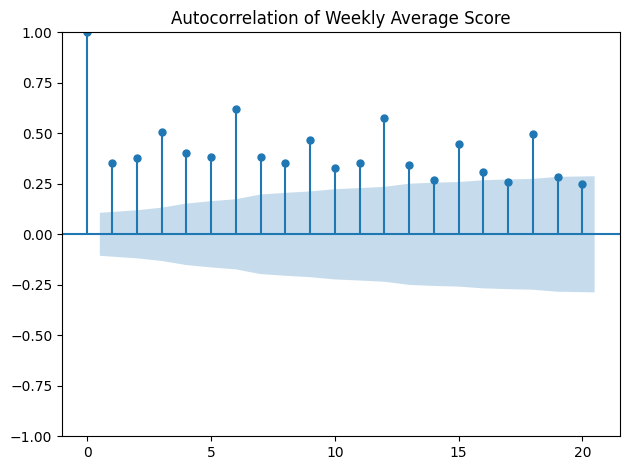

In [18]:
# Drop NaN weeks
weekly_avg_clean = weekly_avg.dropna(subset=[name_score])

# Plot the ACF
plt.figure(figsize=(8, 4))
plot_acf(weekly_avg_clean[name_score], lags=20)
plt.title("Autocorrelation of Weekly Average Score")
plt.tight_layout()
plt.show()

In [19]:
# Drop NaN values just in case
weekly_avg_clean = weekly_avg.dropna(subset=[name_score])

# Run Augmented Dickey-Fuller test
result = adfuller(weekly_avg_clean[name_score], regression='c')

# Extract results
print("ADF Statistic:", result[0])
print("p-value:", result[1])
for key, value in result[4].items():
    print(f"Critical Value ({key}): {value}")

ADF Statistic: -1.2876771283424857
p-value: 0.6347910163839027
Critical Value (1%): -3.450886958636161
Critical Value (5%): -2.870586350823483
Critical Value (10%): -2.5715897843576827


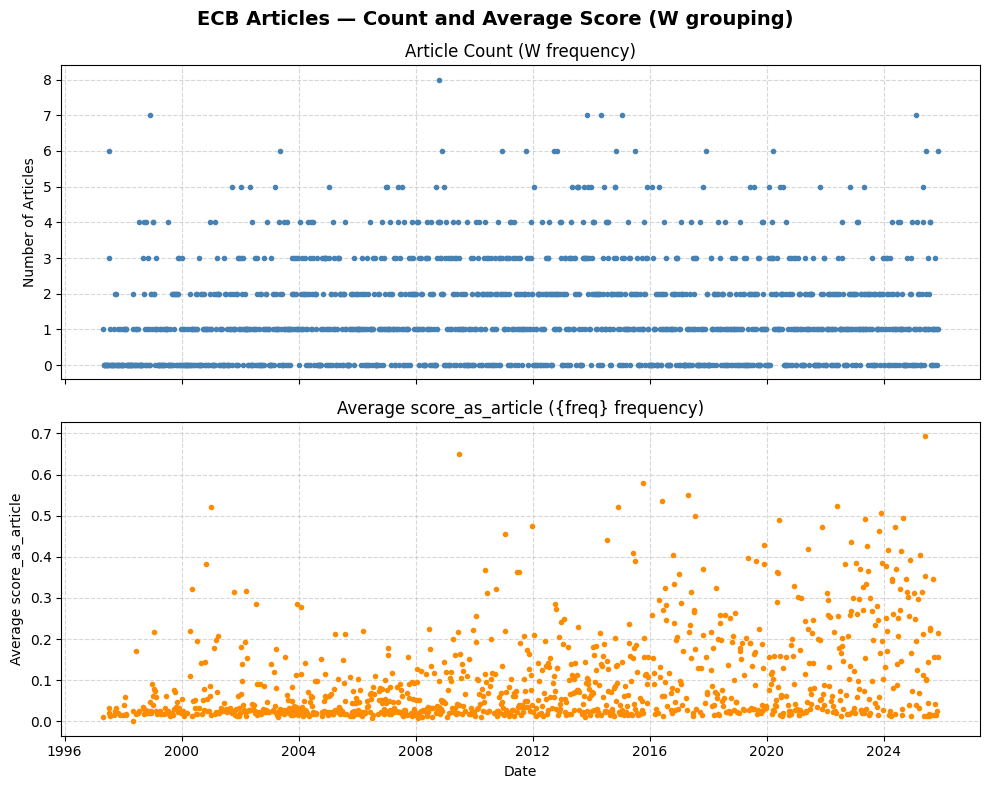

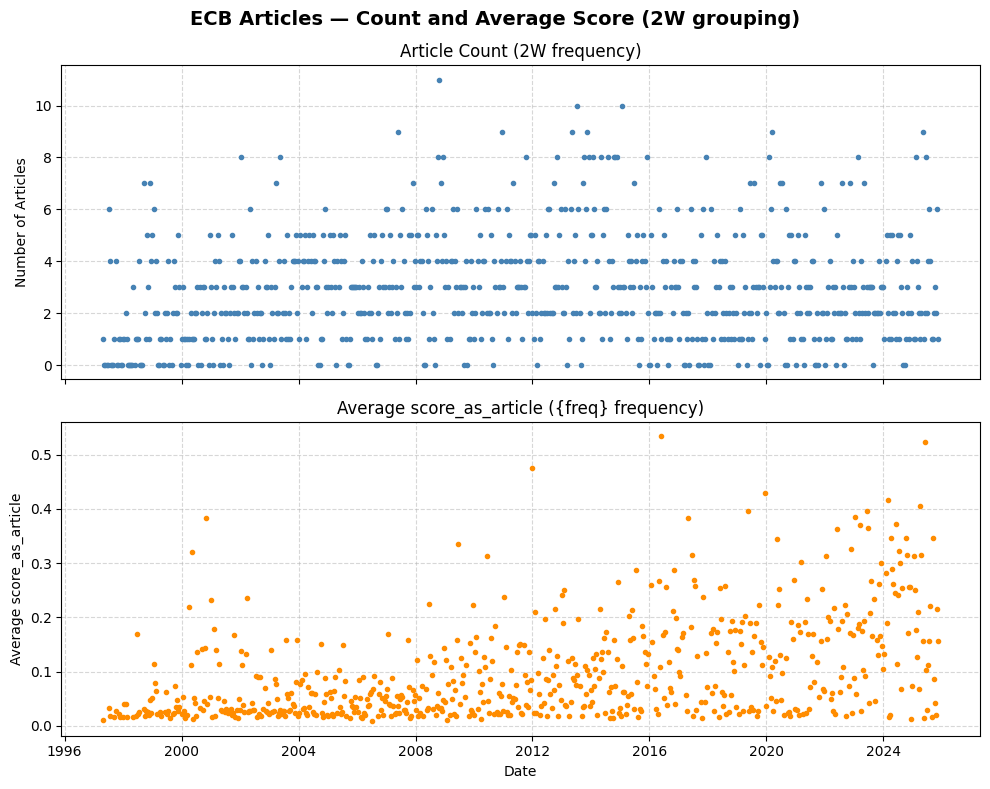

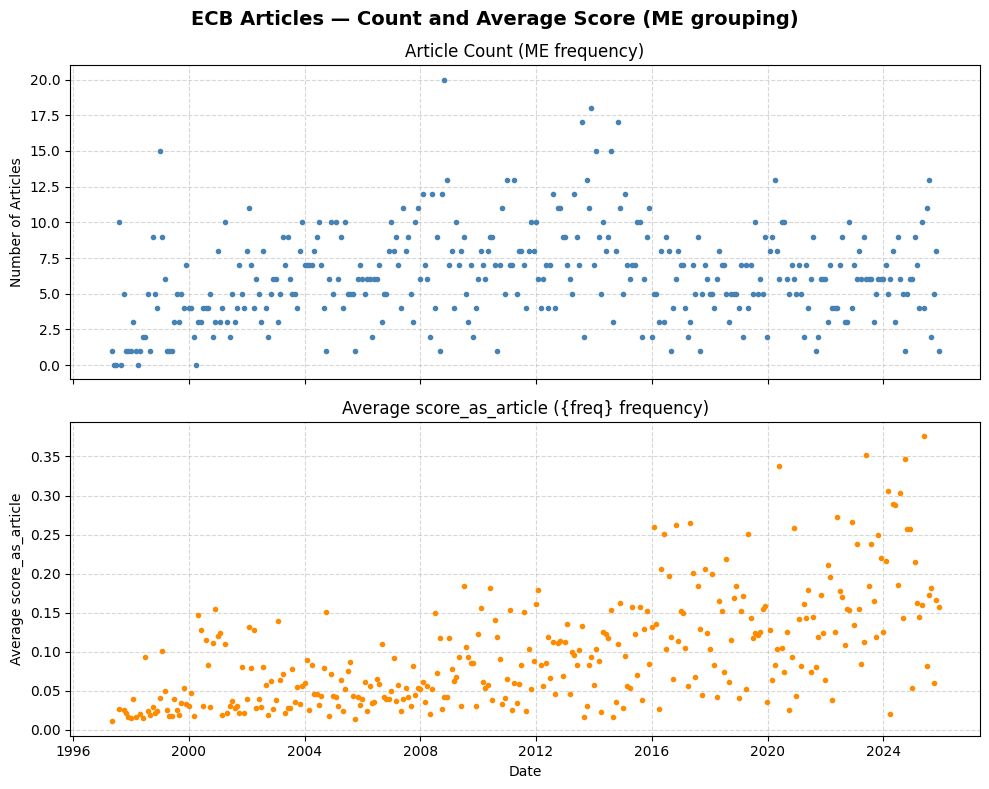

In [20]:
def plot_article_stats(article_df, freq="W", name_score="score_as_article"):
    """
    Compute and plot article statistics (count & average random score)
    grouped by a chosen time frequency.
    
    Parameters
    ----------
    article_df : pd.DataFrame
        Must contain columns "Date" (e.g. "5 November 2025") and "random_score".
    freq : str, optional
        Time frequency for grouping.
        Examples:
            'W'  -> weekly (default)
            '2W' -> biweekly
            'M'  -> monthly
    
    Returns
    -------
    weekly_avg : pd.DataFrame
        DataFrame with Date_parsed, average score, and article count.
    fig : matplotlib.figure.Figure
        Figure object with the two subplots.
    """

    # --- Data preparation ---
    df = article_df.copy()
    df["Date_parsed"] = pd.to_datetime(df["Date"], format="%d %B %Y")

    # --- Aggregation ---
    grouped = (
        df.groupby(pd.Grouper(key="Date_parsed", freq=freq))
        .agg(
            **{
                name_score: (name_score, "mean"),
                "article_count": (name_score, "count")
            }
        )
        .reset_index()
    )

    # --- Plot ---
    fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plot 1: number of articles per period
    ax[0].plot(grouped["Date_parsed"], grouped["article_count"],
               color="steelblue", marker=".", linestyle="")
    ax[0].set_ylabel("Number of Articles")
    ax[0].set_title(f"Article Count ({freq} frequency)")
    ax[0].grid(True, linestyle="--", alpha=0.5)

    # Plot 2: average score per period
    ax[1].plot(grouped["Date_parsed"], grouped[name_score],
               color="darkorange", marker=".", linestyle="")
    ax[1].set_ylabel("Average " + name_score)
    ax[1].set_title(f"Average " + name_score + " ({freq} frequency)")
    ax[1].grid(True, linestyle="--", alpha=0.5)

    # Common labels and layout
    fig.suptitle(f"ECB Articles — Count and Average Score ({freq} grouping)",
                 fontsize=14, fontweight="bold")
    plt.xlabel("Date")
    plt.tight_layout()

    return grouped, fig


weekly_stats_w, fig_weekly_w = plot_article_stats(article_list, freq="W")
weekly_stats_2w, fig_weekly_2w = plot_article_stats(article_list, freq="2W")
weekly_stats_m, fig_weekly_m = plot_article_stats(article_list, freq="ME")

In [21]:
pickle_path = "df_score_by_article_new.pkl"
agreg_freq = "D"
sx5e_returns = get_returns("^STOXX50E", freq=agreg_freq).dropna()
sx5e_returns["date_return"] = pd.to_datetime(sx5e_returns["date_return"])
df_score_by_article_full_detail = pd.read_pickle(pickle_path)
df_score_by_article_full_detail["datetime"] = pd.to_datetime(df_score_by_article_full_detail["Date"])
df_score_by_article_full_detail.head()

,Date,Title,URL,title_file,dictionary,datetime
0,5 November 2025,New data release: ECB wage tracker suggests lo...,https://www.ecb.europa.eu/press/pr/date/2025/h...,New data release_ ECB wage tracker suggests lo...,"{'positivity': [-1.0060063600540161, 0.3107478...",2025-11-05
1,31 October 2025,Results of the September 2025 survey on credit...,https://www.ecb.europa.eu/press/pr/date/2025/h...,Results of the September 2025 survey on credit...,"{'positivity': [-1.101108193397522, 0.01259020...",2025-10-31
2,31 October 2025,Results of the ECB Survey of Professional Fore...,https://www.ecb.europa.eu/press/pr/date/2025/h...,Results of the ECB Survey of Professional Fore...,"{'positivity': [-1.101108193397522, 0.62667286...",2025-10-31
3,30 October 2025,Eurosystem moving to next phase of digital eur...,https://www.ecb.europa.eu/press/pr/date/2025/h...,Eurosystem moving to next phase of digital eur...,"{'positivity': [-1.1370823383331299, 1.7842442...",2025-10-30
4,28 October 2025,ECB Consumer Expectations Survey results – Sep...,https://www.ecb.europa.eu/press/pr/date/2025/h...,ECB Consumer Expectations Survey results _ Sep...,"{'positivity': [-1.03248929977417, -0.79902720...",2025-10-28


In [22]:
pickle_path = "df_score_by_article_new.pkl"
agreg_freq = "D"
sx5e_returns = get_returns("^STOXX50E", freq=agreg_freq).dropna()
sx5e_returns["date_return"] = pd.to_datetime(sx5e_returns["date_return"])
df_score_by_article_full_detail = pd.read_pickle(pickle_path)
df_score_by_article_full_detail["datetime"] = pd.to_datetime(df_score_by_article_full_detail["Date"])

# --- Align start dates ---
min_common_date = max(
    sx5e_returns["date_return"].min(),
    df_score_by_article_full_detail["datetime"].min()
)

sx5e_returns = sx5e_returns[sx5e_returns["date_return"] >= min_common_date].copy()
df_score_by_article_full_detail = df_score_by_article_full_detail[df_score_by_article_full_detail["datetime"] >= min_common_date].copy()

# --- Merge as-of (forward, strict) ---
study_df = pd.merge_asof(
    df_score_by_article_full_detail.sort_values("datetime"),
    sx5e_returns.sort_values("date_return"),
    left_on="datetime",
    right_on="date_return",
    direction="forward",
    allow_exact_matches=False
).reset_index(drop=True)

def apply_softmax_to_dict(d):
    """
    Apply softmax to the keys 'positivity', 'negativity', 'neutrality' in the dictionary.
    Keeps other keys unchanged. Returns np.arrays for speed.
    """
    if d is None:
        return None  # skip missing values
    
    d_new = d.copy()
    for key in ["positivity", "negativity", "neutrality"]:
        values = d.get(key)
        if values is None:
            d_new[key] = None
        else:
            d_new[key] = softmax(np.array(values))  # keep as numpy array
    d_new["nb_token"] = np.array(d.get("nb_token", []))
    return d_new

# Apply optimized function
study_df["dictionary_softmax"] = study_df["dictionary"].apply(apply_softmax_to_dict)

# Check first line
study_df.loc[0, "dictionary_softmax"]


{'positivity': array([0.0177137 , 0.25763707, 0.03253788, 0.12974639, 0.28139691,
        0.28096806]),
 'negativity': array([0.42818468, 0.15062924, 0.17232449, 0.08132678, 0.06950543,
        0.09802938]),
 'neutrality': array([0.43565439, 0.02026662, 0.32400653, 0.14757468, 0.04730095,
        0.02519683]),
 'nb_token': array([  5,  25,  84,  93, 147, 103])}

In [23]:
import numpy as np
from scipy.special import softmax

def apply_softmax_per_token_safe(d):
    """
    Apply softmax across categories per token, safely handling scalars, lists, or None.
    """
    if d is None:
        return None

    def to_array(x):
        # Convert scalar to array of length 1, leave list/array as np.array
        if x is None:
            return np.array([])
        if isinstance(x, (int, float, np.float32, np.float64)):
            return np.array([x], dtype=float)
        return np.array(x, dtype=float)

    pos = to_array(d.get("positivity"))
    neg = to_array(d.get("negativity"))
    neu = to_array(d.get("neutrality"))

    n = max(len(pos), len(neg), len(neu))
    if n == 0:
        return {
            "positivity": np.array([]),
            "negativity": np.array([]),
            "neutrality": np.array([]),
            "nb_token": d.get("nb_token")
        }

    # Pad arrays to the same length
    pos = np.pad(pos, (0, n - len(pos)), 'constant')
    neg = np.pad(neg, (0, n - len(neg)), 'constant')
    neu = np.pad(neu, (0, n - len(neu)), 'constant')

    # Stack and apply softmax per token
    stacked = np.vstack([pos, neg, neu]).T  # shape (n_tokens, 3)
    probs = softmax(stacked, axis=1)

    return {
        "positivity": probs[:, 0],
        "negativity": probs[:, 1],
        "neutrality": probs[:, 2],
        "nb_token": d.get("nb_token")
    }

# Apply to dataframe
study_df["dictionary_softmax_tokens"] = study_df["dictionary"].apply(apply_softmax_per_token_safe)

# Check first row
study_df.loc[0, "dictionary_softmax_tokens"]


{'positivity': array([0.03329933, 0.90082394, 0.07935595, 0.4299427 , 0.83250463,
        0.89708867]),
 'negativity': array([0.0273549 , 0.01789859, 0.01428286, 0.00915855, 0.00698818,
        0.01063684]),
 'neutrality': array([0.93934577, 0.08127747, 0.90636119, 0.56089875, 0.16050719,
        0.09227449]),
 'nb_token': [5, 25, 84, 93, 147, 103]}

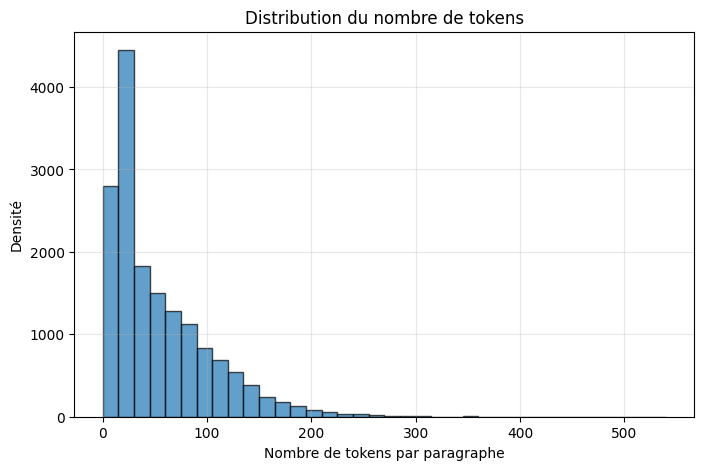

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Collect all valid token counts
all_tokens = []

for d in study_df["dictionary_softmax_tokens"].dropna():
    if isinstance(d, dict) and "nb_token" in d and d["nb_token"] is not None:
        val = d["nb_token"]
        if isinstance(val, (list, np.ndarray)):
            all_tokens.extend(val)
        else:
            all_tokens.append(val)

# Convert to numpy array
all_tokens = np.array(all_tokens, dtype=float)
bins = np.arange(0, 551, 15)

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(all_tokens, bins=bins, density=False, alpha=0.7, edgecolor="black")
plt.xlabel("Tokens per paragraph")
plt.ylabel("Count")
plt.title("Distribution of paragraph token counts")
plt.grid(alpha=0.3)
plt.show()


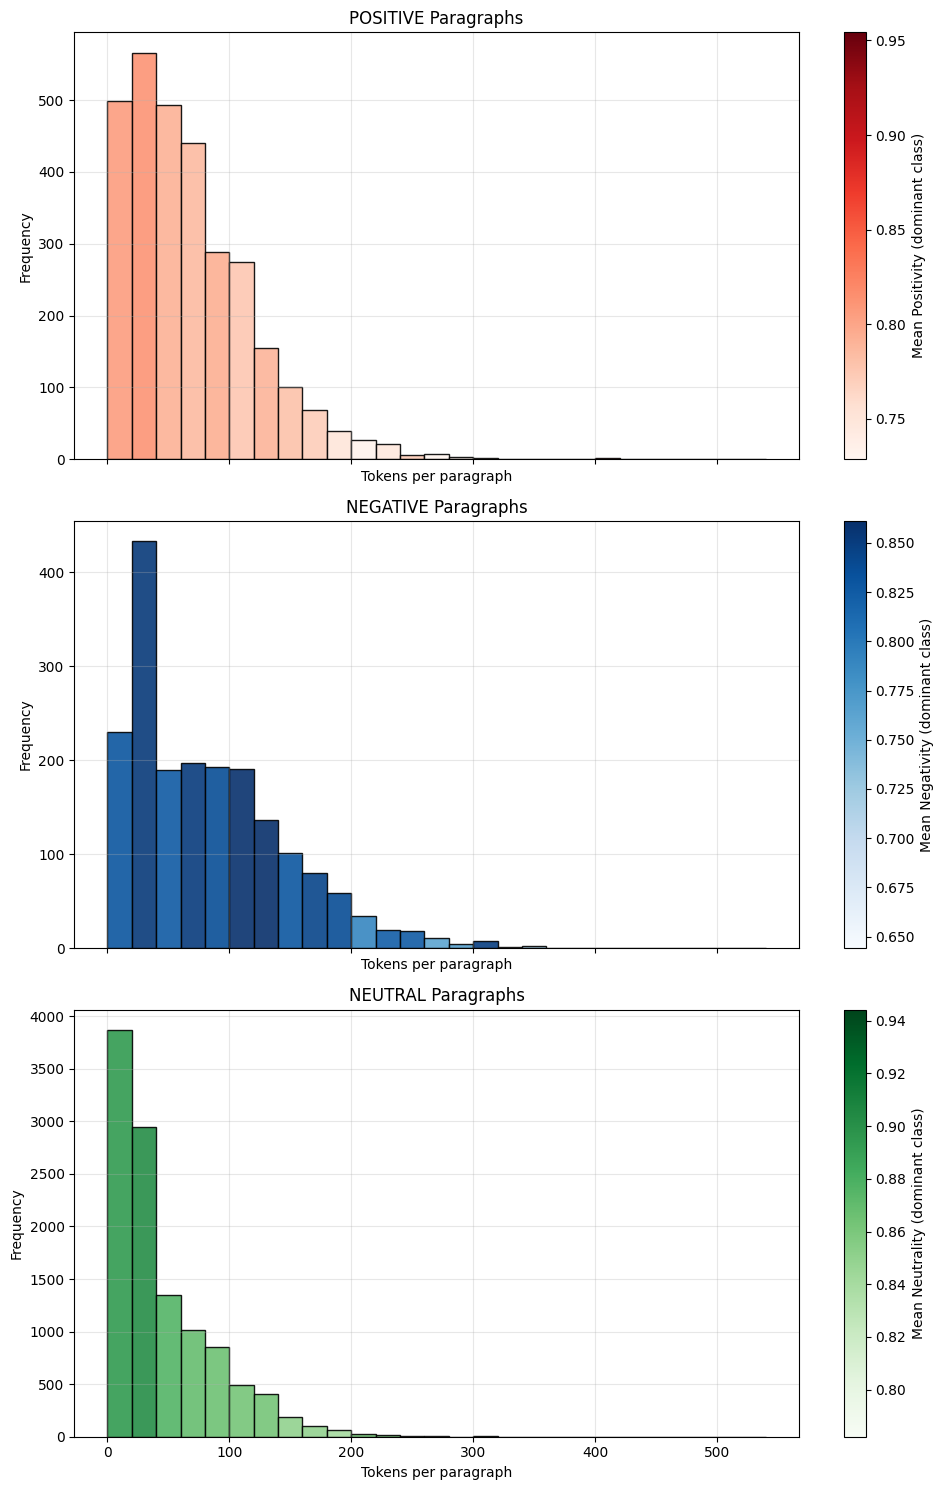

Total POSITIVE paragraphs: 2994
Total NEGATIVE paragraphs: 1906
Total NEUTRAL paragraphs : 11351


In [68]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# --- 1. Extract tokens and probabilities ---
all_tokens, all_pos, all_neg, all_neu = [], [], [], []

def flatten(x):
    """Flatten a nested list or array."""
    if isinstance(x, (list, np.ndarray)):
        for i in x:
            yield from flatten(i)
    else:
        yield x

for d in study_df["dictionary_softmax_tokens"].dropna():
    if not isinstance(d, dict):
        continue

    tokens = d.get("nb_token")
    pos = d.get("positivity")
    neg = d.get("negativity")
    neu = d.get("neutrality")

    if tokens is None or pos is None or neg is None or neu is None:
        continue

    tokens = list(flatten(tokens))
    pos = list(flatten(pos))
    neg = list(flatten(neg))
    neu = list(flatten(neu))

    min_len = min(len(tokens), len(pos), len(neg), len(neu))
    if min_len == 0:
        continue

    all_tokens.extend(tokens[:min_len])
    all_pos.extend(pos[:min_len])
    all_neg.extend(neg[:min_len])
    all_neu.extend(neu[:min_len])

# --- 2. Convert to numpy arrays ---
all_tokens = np.array(all_tokens, dtype=float)
all_pos = np.array(all_pos, dtype=float)
all_neg = np.array(all_neg, dtype=float)
all_neu = np.array(all_neu, dtype=float)

# --- 3. Determine dominant class for each paragraph ---
classes = np.argmax(np.vstack([all_pos, all_neg, all_neu]), axis=0)  # 0=pos, 1=neg, 2=neu

# --- 4. Define bins ---
bins = np.arange(0, 551, 20)
bin_indices = np.digitize(all_tokens, bins) - 1

# --- 5. Compute counts and mean values per bin ---
def bin_stats(class_mask, class_probs):
    counts = []
    means = []
    for i in range(len(bins) - 1):
        mask = (bin_indices == i) & class_mask
        if mask.any():
            counts.append(mask.sum())
            means.append(np.nanmean(class_probs[mask]))
        else:
            counts.append(0)
            means.append(np.nan)
    return np.array(counts), np.array(means)

mask_pos = classes == 0
mask_neg = classes == 1
mask_neu = classes == 2

counts_pos, mean_pos = bin_stats(mask_pos, all_pos)
counts_neg, mean_neg = bin_stats(mask_neg, all_neg)
counts_neu, mean_neu = bin_stats(mask_neu, all_neu)

# --- 6. Plot function ---
def plot_hist(ax, counts, mean_values, cmap, title, label):
    norm = Normalize(vmin=np.nanmin(mean_values), vmax=np.nanmax(mean_values))
    colors = cmap(norm(mean_values))
    ax.bar(bins[:-1], counts, width=np.diff(bins), align="edge",
           edgecolor="black", color=colors, alpha=0.9)
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label(f"Mean {label} (dominant class)")
    ax.set_title(title)
    ax.set_xlabel("Tokens per paragraph")
    ax.set_ylabel("Frequency")
    ax.grid(alpha=0.3)

# --- 7. Plot results ---
fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

plot_hist(axes[0], counts_pos, mean_pos, plt.cm.Reds, "POSITIVE Paragraphs", "Positivity")
plot_hist(axes[1], counts_neg, mean_neg, plt.cm.Blues, "NEGATIVE Paragraphs", "Negativity")
plot_hist(axes[2], counts_neu, mean_neu, plt.cm.Greens, "NEUTRAL Paragraphs", "Neutrality")

plt.tight_layout()
plt.show()

# --- 8. Print totals ---
total_pos = mask_pos.sum()
total_neg = mask_neg.sum()
total_neu = mask_neu.sum()

print(f"Total POSITIVE paragraphs: {total_pos}")
print(f"Total NEGATIVE paragraphs: {total_neg}")
print(f"Total NEUTRAL paragraphs : {total_neu}")

We observe that we have more positive paragraphs than negatives, lets have a look if there are some text that mix positive and negative informations

In [59]:
import numpy as np

def classify_paragraphs(d):
    """Return the dominant class for each paragraph"""
    if not isinstance(d, dict):
        return None
    pos, neg, neu = d.get("positivity"), d.get("negativity"), d.get("neutrality")
    if pos is None or neg is None or neu is None:
        return None
    pos, neg, neu = np.array(pos), np.array(neg), np.array(neu)
    classes = np.argmax(np.vstack([pos, neg, neu]), axis=0)  # 0=positive, 1=negative, 2=neutral
    return classes

study_df["paragraph_classes"] = study_df["dictionary_softmax_tokens"].apply(classify_paragraphs)

In [60]:
study_df["paragraph_classes"].head()

0                            [2, 0, 2, 2, 0, 0]
1                                     [2, 2, 2]
2             [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
3    [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
4                               [2, 2, 2, 2, 2]
Name: paragraph_classes, dtype: object

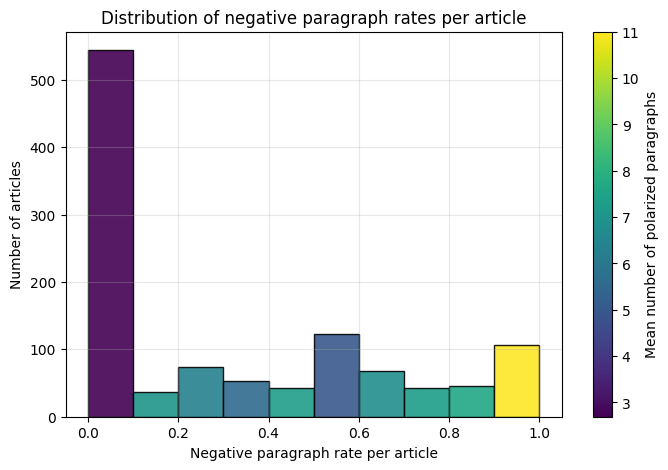

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# Extract only positive and negative paragraphs
share_data = []
number_polarized_paragraphs = []
article_indices = []

for idx, d in enumerate(study_df["paragraph_classes"]):
    pos_neg_mask = (d == 0) | (d == 1)
    d_pos_neg = d[pos_neg_mask]
    
    n = len(d_pos_neg)
    if n == 0:
        continue
    
    n_neg = np.sum(d_pos_neg == 1)
    share_data.append(n_neg / n)
    number_polarized_paragraphs.append(n)
    article_indices.append(idx)

negative_rate = np.array(share_data)
number_polarized_paragraphs = np.array(number_polarized_paragraphs)
article_indices = np.array(article_indices)

# Histogram setup
bins = np.arange(0, 1.1, 0.1)
bin_number_index = np.digitize(negative_rate, bins)
mean_number_paragraph = np.zeros(len(bins)-1)
num_obs = np.zeros(len(bins)-1)

# Store article indices per bin
index_articles_per_bin = [[] for _ in range(len(bins)-1)]

for i in range(len(bins)-1):
    mask = bin_number_index == i+1
    if mask.any():
        mean_number_paragraph[i] = np.mean(number_polarized_paragraphs[mask])
        num_obs[i] = np.sum(mask)
        index_articles_per_bin[i] = article_indices[mask].tolist()
    else:
        mean_number_paragraph[i] = 0
        index_articles_per_bin[i] = []

# Histogram with color based on mean number of paragraphs
counts, edges = np.histogram(negative_rate, bins=bins)
norm = Normalize(vmin=np.min(mean_number_paragraph), vmax=np.max(mean_number_paragraph))
colors = plt.cm.viridis(norm(mean_number_paragraph))

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(edges[:-1], counts, width=np.diff(edges), align='edge',
              color=colors, edgecolor='black', alpha=0.9)

sm = ScalarMappable(cmap=plt.cm.viridis, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Mean number of polarized paragraphs")

ax.set_xlabel("Negative paragraph rate per article")
ax.set_ylabel("Number of articles")
ax.set_title("Distribution of negative paragraph rates per article")
ax.grid(alpha=0.3)
plt.show()


In [67]:
# Bin-level statistics
bin_stats = []

for i, bin_indices in enumerate(index_articles_per_bin):
    if len(bin_indices) == 0:
        bin_stats.append({
            "bin": i,
            "mean_pos_par": 0,
            "mean_neg_par": 0,
            "mean_neut_par": 0,
            "mean_total_par": 0,
            "mean_tokens_pos": 0,
            "mean_tokens_neg": 0,
            "mean_tokens_neut": 0,
            "mean_tokens_total": 0,
            "num_articles": 0
        })
        continue
    
    # Initialize lists
    num_pos_list, num_neg_list, num_neut_list, num_total_list = [], [], [], []
    tokens_pos_list, tokens_neg_list, tokens_neut_list, tokens_total_list = [], [], [], []
    
    for idx in bin_indices:
        info = study_df["paragraph_info"].iloc[idx]
        classes = info["classes"]
        nb_tokens = info["nb_tokens"]
        
        num_pos_list.append(np.sum(classes == 0))
        num_neg_list.append(np.sum(classes == 1))
        num_neut_list.append(np.sum(classes == 2))
        num_total_list.append(len(classes))
        
        tokens_total_list.append(np.sum(nb_tokens))  # total tokens per article
        
        if np.sum(classes == 0) > 0:
            tokens_pos_list.append(np.mean(nb_tokens[classes == 0]))
        if np.sum(classes == 1) > 0:
            tokens_neg_list.append(np.mean(nb_tokens[classes == 1]))
        if np.sum(classes == 2) > 0:
            tokens_neut_list.append(np.mean(nb_tokens[classes == 2]))
    
    bin_stats.append({
        "bin": i,
        "mean_pos_par": np.mean(num_pos_list),
        "mean_neg_par": np.mean(num_neg_list),
        "mean_neut_par": np.mean(num_neut_list),
        "mean_total_par": np.mean(num_total_list),
        "mean_tokens_pos": np.mean(tokens_pos_list) if tokens_pos_list else 0,
        "mean_tokens_neg": np.mean(tokens_neg_list) if tokens_neg_list else 0,
        "mean_tokens_neut": np.mean(tokens_neut_list) if tokens_neut_list else 0,
        "mean_tokens_total": np.mean(tokens_total_list),
        "num_articles": len(bin_indices)
    })

# Print results
print("Summary statistics per bin:")
print("Each bin shows the number of articles, average paragraph counts by class, and average tokens per class and per article.\n")

for stats in bin_stats:
    print(f"Bin {stats['bin']} ({stats['num_articles']} articles) : "
          f"Paragraphs Pos={stats['mean_pos_par']:.2f}, "
          f"Neg={stats['mean_neg_par']:.2f}, "
          f"Neut={stats['mean_neut_par']:.2f}, "
          f"Total Paragraphs={stats['mean_total_par']:.2f} | "
          f"Tokens Pos={stats['mean_tokens_pos']:.2f}, "
          f"Neg={stats['mean_tokens_neg']:.2f}, "
          f"Neut={stats['mean_tokens_neut']:.2f}, "
          f"Total Tokens={stats['mean_tokens_total']:.2f}")



Summary statistics per bin:
Each bin shows the number of articles, average paragraph counts by class, and average tokens per class and per article.

Bin 0 (544 articles) : Paragraphs Pos=2.69, Neg=0.00, Neut=6.95, Total Paragraphs=9.64 | Tokens Pos=62.49, Neg=0.00, Neut=48.49, Total Tokens=488.56
Bin 1 (36 articles) : Paragraphs Pos=6.00, Neg=1.03, Neut=5.39, Total Paragraphs=12.42 | Tokens Pos=85.09, Neg=98.19, Neut=57.20, Total Tokens=892.58
Bin 2 (74 articles) : Paragraphs Pos=4.80, Neg=1.54, Neut=6.84, Total Paragraphs=13.18 | Tokens Pos=84.30, Neg=100.25, Neut=49.74, Total Tokens=866.50
Bin 3 (53 articles) : Paragraphs Pos=3.62, Neg=1.92, Neut=8.58, Total Paragraphs=14.13 | Tokens Pos=75.81, Neg=88.51, Neut=49.33, Total Tokens=853.91
Bin 4 (43 articles) : Paragraphs Pos=4.26, Neg=3.05, Neut=7.44, Total Paragraphs=14.74 | Tokens Pos=71.05, Neg=88.24, Neut=45.40, Total Tokens=891.72
Bin 5 (122 articles) : Paragraphs Pos=2.34, Neg=2.64, Neut=8.75, Total Paragraphs=13.74 | Tokens Pos=

We observe that negative paragraph tend to be longer than positive one

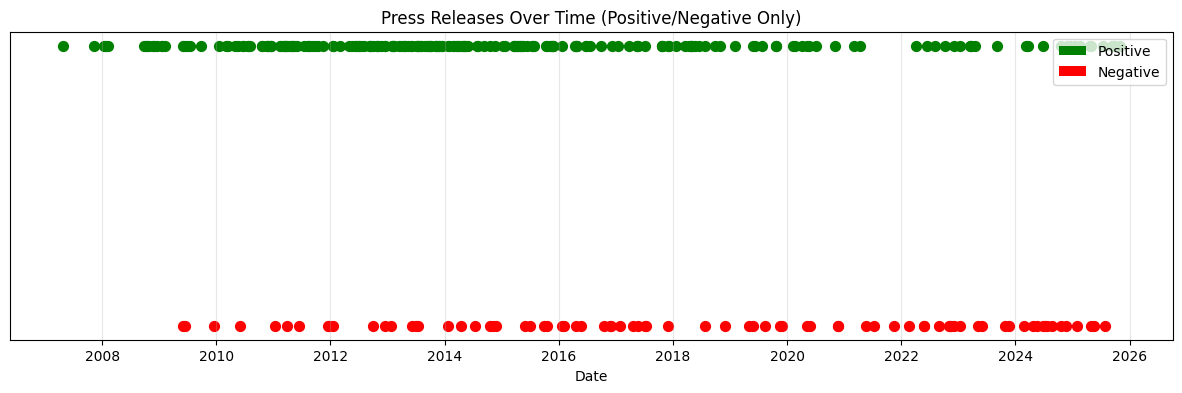

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Patch

# Compute majority sentiment per article
def majority_sentiment(paragraph_classes):
    if paragraph_classes is None or len(paragraph_classes) == 0:
        return np.nan
    counts = np.bincount(paragraph_classes)
    return np.argmax(counts)

study_df["majority_sentiment"] = study_df["paragraph_classes"].apply(majority_sentiment)

# Vertical offsets for clarity
y_offset = {0: 0.1,   # positive
            1: -0.1}  # negative

# Keep only positive/negative articles
df_filtered = study_df.dropna(subset=["datetime", "majority_sentiment"])
df_filtered = df_filtered[df_filtered["majority_sentiment"] != 2]

# Plotting
plt.figure(figsize=(15, 4))

for idx, row in df_filtered.iterrows():
    sentiment = row["majority_sentiment"]
    plt.scatter(
        row["datetime"],
        y_offset[sentiment],           # <-- small vertical shift
        color="green" if sentiment == 0 else "red",
        s=50
    )

plt.yticks([])  # remove the y axis since height has no meaning
plt.xlabel("Date")
plt.title("Press Releases Over Time (Positive/Negative Only)")
plt.grid(axis="x", alpha=0.3)

# Custom legend
legend_elements = [
    Patch(facecolor="green", label="Positive"),
    Patch(facecolor="red", label="Negative")
]
plt.legend(handles=legend_elements, loc="upper right")

plt.show()
